### 9.2.2.10.1 Power Stage Poles and Zeroes

In [1]:
from numpy import pi,sqrt

# Output load
Rout = 137
# Primary inductance
Lp = 476e-6
Ls = 38.1e-3
# Primary to secondary turns ratio
Nps = sqrt(Lp/Ls)
# Maximum duty cycle
D = 0.3 # (0.3 para cada mos)
#fsw = 75e3 #la que ve cada transistor. Del PWM sale 150kHz
fsw = 150e3 # la que ve el micro
Vin = 30
Vout = 112.5
Rcs = 0.1
Cout = 1e-6
Vbulkmin = 25
Resr = 0.2

rL1 = 0.1
rL2 = 2

Vinmin = 25
Rramp = 10e3
Cramp = 1e-9

# Internal current sense gain
Acs = 3

In [2]:
# Inductance for DCM/CCM boundary mode operation
Lpcrit = Rout*(Nps**2)/(2*fsw)*((Vin/(Vin+Vout*Nps))**2)

print(f'Lp \t= {Lp}')
print(f'Lpcrit \t= {Lpcrit}')
if Lp > Lpcrit:
    print("CCM - And that's good")
else:
    print("DCM - oof.mp3")

Lp 	= 0.000476
Lpcrit 	= 2.8328464886919246e-06
CCM - And that's good


In [3]:
# D = Nps*Vout/(Vbulkmin + (Nps*Vout))
tauL = 2*Lp*fsw/(Rout * (Nps**2))
M = Vout*Nps/Vbulkmin

# DC open-loop gain
Go = Rout*Nps/(Rcs*Acs)/(1+2*M+((1-D)**2)/tauL)

wESRz = 1/(Resr*Cout)
fESRz = 1/(2*pi*Resr*Cout)
print(f'fESRz = {fESRz}')

fESRz = 795774.7154594767


In [4]:
wRHPz = Rout*((1-D)**2)*(Nps**2)/(Lp*D)
fRHPz = wRHPz/(2*pi)
print(f'fRHPz = {fRHPz}')
# EN CASO DE QUE NO FUNCIONE, PROBAR CON minimum input and maximum load condition
# que me va a dar un fRHPz mucho peor! (cambiar el D acorde podria servir)

fRHPz = 934.7393989290406


In [5]:
wp1 = (((1-D)**3)/tauL + 1 + D) / (Rout*Cout)
fp1 = wp1 / (2*pi)
wp2 = pi*fsw
fp2 = fsw/2
print(f'fp1 = {fp1} - Polo dominante')
print(f'fp2 = {fp2} - Polo doble')

fp1 = 1515.0054277278416 - Polo dominante
fp2 = 75000.0 - Polo doble


### 9.2.2.10.2 Slope Compensation

In [6]:
## Inductor rising slope
#Sn = Vinmin*Rcs/Lp
## Slope compenation factor
##Mc = Se/Sn + 1
Mideal = (1/pi + 0.5)/(1-D)
Mc = Mideal # TODO: ok?
## Compensation slope
#Se = (Mc - 1)*Sn

## Quality coefficient
Qp = 1/(pi * (Mc * (1-D) - 0.5))

###################################

#VOSCpp = 1.7
#tONmin = D/fsw
#SOSC = VOSCpp/tONmin

#RCSF = Rramp/(SOSC/Se-1) # TODO: check
#print(f'R_CSF = {RCSF}')

### 9.2.2.10.3 Open-Loop Gain

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# sys = signal.TransferFunction([1, 0],[0, 1])
# w, mag, phase = signal.bode(sys)

# plt.semilogx(w,mag)



# s = signal.TransferFunction([1,0],[1])
# sys = 2*s+s**2

# w, mag, phase = signal.bode(sys)
# plt.semilogx(w,mag)

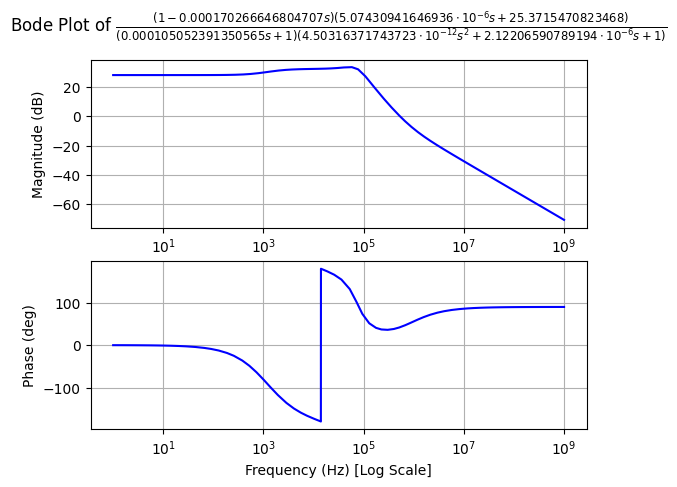

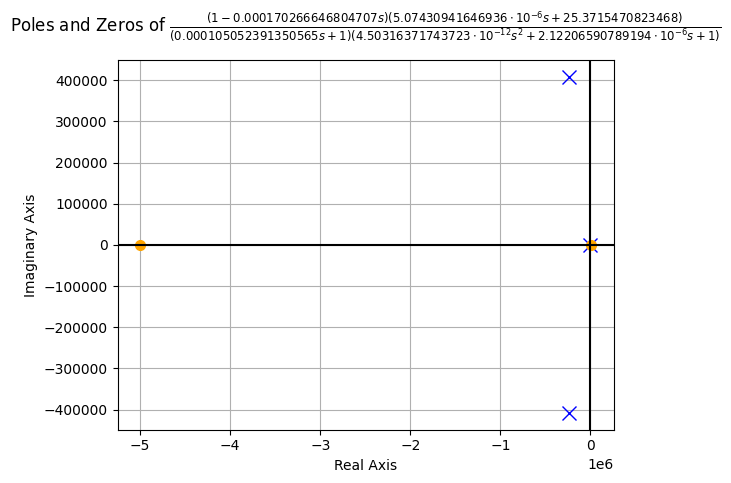

In [8]:
import sympy as sp
#from sympy.plotting import plot
from sympy.physics.control.lti import TransferFunction as TF
from sympy.physics.control.control_plots import bode_plot,pole_zero_plot

s = sp.symbols('s',complex=True)
Hopen = Go * (1+s/wESRz)*(1-s/wRHPz)/(1+s/wp1)/(1+s/(wp2*Qp)+(s**2)/(wp2**2))
tf = TF(*Hopen.as_numer_denom(),s)
bode_plot(tf, 0, 9, freq_unit="Hz", phase_unit="deg")
pole_zero_plot(tf)

# bode_plot(TF(Hopen.as_numer_denom(),s))
#sp.plotting.plot(Hopen, (s,1,1e9))


### 9.2.2.10.4 Compensation Loop

In [9]:
from numpy import angle

fBW = fRHPz/4

Hopen_fBW = complex(Hopen.evalf(subs={s: 2j*pi*fBW}))
print(Hopen_fBW)
print(f'|Hopen(fBW)| = {abs(Hopen_fBW)}')
print(f'phase(Hopen(fBW)) = {angle(Hopen_fBW,deg=True)}°')

(23.79804823025463-10.085269945046527j)
|Hopen(fBW)| = 25.84685221519217
phase(Hopen(fBW)) = -22.966530958145167°


In [10]:
# divider current
IFRref = 1e-3
# input current for the TL431
#    I_REF_TL431 = 2e-6
# TL431 reference voltage
refTL431 = 2.495

# Top divider resistor
RFBU = (Vout-refTL431)/IFRref # TODO: ver si es el que se usa en la simu
# el otro
RFBB = refTL431/(Vout-refTL431)*RFBU
print(f'RFBU = {RFBU}')
print(f'RFBB = {RFBB}')

RFBU = 110005.0
RFBB = 2495.0000000000005


In [11]:
# Compensator zero
fCOMPz = fBW/10
wCOMPz = fCOMPz*2*pi
print(f'fCOMPz = {fCOMPz}')

fCOMPz = 23.368484973226014


In [12]:
cCOMPz = 0.01e-6
rCOMPz = 1/(wCOMPz * cCOMPz)
print(f'cCOMPz = {cCOMPz}')
print(f'rCOMPz = {rCOMPz}')

cCOMPz = 1e-08
rCOMPz = 681066.5872188292


6.19123300957983 + 9.09049588655061e-6/(s + 1.0e-8)


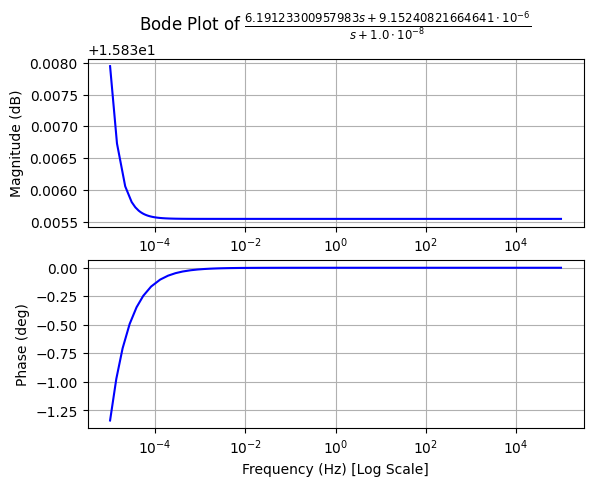

In [15]:
# ZENER = 10V
# current to bias TL431 = 10mA
RTLbias = 1e3

GTL431 = (rCOMPz + 1 / (s + cCOMPz))/RFBU
print(GTL431)
tf2 = TF(*GTL431.as_numer_denom(),s)
bode_plot(tf2,-5,5, freq_unit='Hz', phase_unit='deg')

In [14]:
from numpy import min
flowestZ = min([fESRz,fRHPz])
#print(flowestZ)

Ropto = 1e3
rCOMPp = 10000
cCOMPp = 1/(2*pi*flowestZ*rCOMPp)

print(f'Ropto = {Ropto}')
print(f'rCOMPp = {rCOMPp}')
print(f'cCOMPp = {cCOMPp}')

Ropto = 1000.0
rCOMPp = 10000
cCOMPp = 1.7026664680470727e-08
